
# Laplacian segmentation

This notebook implements the laplacian segmentation method of
[McFee and Ellis, 2014](https://zenodo.org/record/1415778),
with a couple of minor stability improvements.

Throughout the example, we will refer to equations in the paper by number, so it will be
helpful to read along.


In [ ]:
# Code source: Brian McFee
# License: ISC

Imports
  - numpy for basic functionality
  - scipy for graph Laplacian
  - matplotlib for visualization
  - sklearn.cluster for K-Means




In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

import sklearn.cluster

import librosa

First, we'll load in a song



In [2]:
y, sr = librosa.load(librosa.ex('fishin'))

c:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


Next, we'll compute and plot a log-power CQT



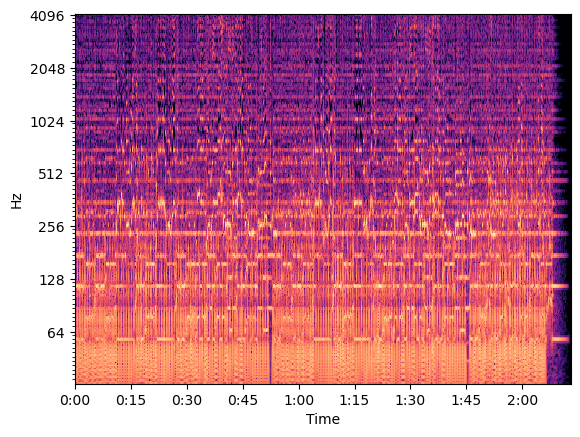

In [3]:
BINS_PER_OCTAVE = 12 * 3
N_OCTAVES = 7
C = librosa.amplitude_to_db(np.abs(librosa.cqt(y=y, sr=sr,
                                        bins_per_octave=BINS_PER_OCTAVE,
                                        n_bins=N_OCTAVES * BINS_PER_OCTAVE)),
                            ref=np.max)

fig, ax = plt.subplots()
librosa.display.specshow(C, y_axis='cqt_hz', sr=sr,
                         bins_per_octave=BINS_PER_OCTAVE,
                         x_axis='time', ax=ax)

To reduce dimensionality, we'll beat-synchronous the CQT



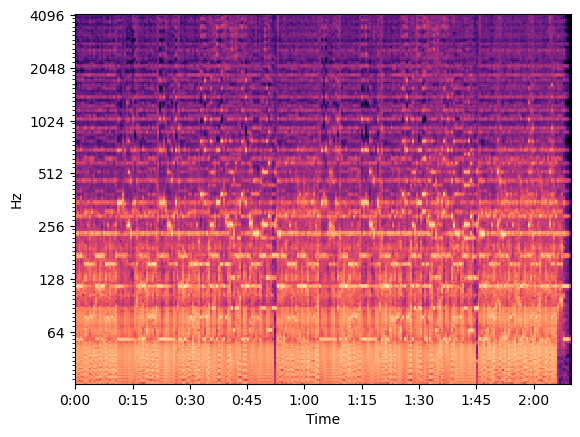

In [5]:
tempo, beats = librosa.beat.beat_track(y=y, sr=sr, trim=False)
Csync = librosa.util.sync(C, beats, aggregate=np.median)

# For plotting purposes, we'll need the timing of the beats
# we fix_frames to include non-beat frames 0 and C.shape[1] (final frame)
beat_times = librosa.frames_to_time(librosa.util.fix_frames(beats,
                                                            x_min=0),
                                    sr=sr)

fig, ax = plt.subplots()
librosa.display.specshow(Csync, bins_per_octave=12*3,
                         y_axis='cqt_hz', x_axis='time',
                         x_coords=beat_times, ax=ax)

Let's build a weighted recurrence matrix using beat-synchronous CQT
(Equation 1)
width=3 prevents links within the same bar
mode='affinity' here implements S_rep (after Eq. 8)



In [6]:
R = librosa.segment.recurrence_matrix(Csync, width=3, mode='affinity',
                                      sym=True)

# Enhance diagonals with a median filter (Equation 2)
df = librosa.segment.timelag_filter(scipy.ndimage.median_filter)
Rf = df(R, size=(1, 7))

Now let's build the sequence matrix (S_loc) using mfcc-similarity

  $R_\text{path}[i, i\pm 1] = \exp(-\|C_i - C_{i\pm 1}\|^2 / \sigma^2)$

Here, we take $\sigma$ to be the median distance between successive beats.




In [7]:
mfcc = librosa.feature.mfcc(y=y, sr=sr)
Msync = librosa.util.sync(mfcc, beats)

path_distance = np.sum(np.diff(Msync, axis=1)**2, axis=0)
sigma = np.median(path_distance)
path_sim = np.exp(-path_distance / sigma)

R_path = np.diag(path_sim, k=1) + np.diag(path_sim, k=-1)

And compute the balanced combination (Equations 6, 7, 9)



In [8]:
deg_path = np.sum(R_path, axis=1)
deg_rec = np.sum(Rf, axis=1)

mu = deg_path.dot(deg_path + deg_rec) / np.sum((deg_path + deg_rec)**2)

A = mu * Rf + (1 - mu) * R_path

Plot the resulting graphs (Figure 1, left and center)



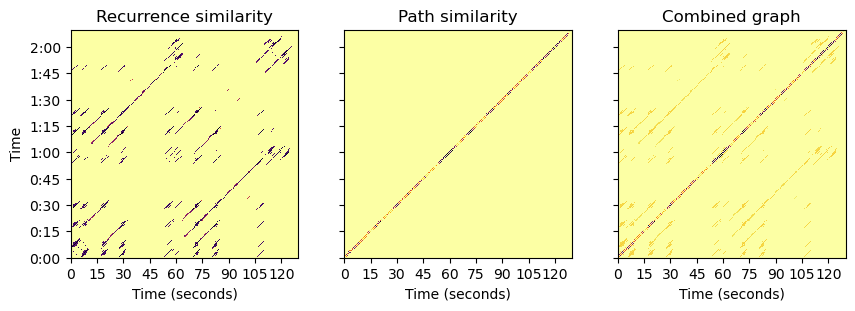

In [9]:
fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(10, 4))
librosa.display.specshow(Rf, cmap='inferno_r', y_axis='time', x_axis='s',
                         y_coords=beat_times, x_coords=beat_times, ax=ax[0])
ax[0].set(title='Recurrence similarity')
ax[0].label_outer()
librosa.display.specshow(R_path, cmap='inferno_r', y_axis='time', x_axis='s',
                         y_coords=beat_times, x_coords=beat_times, ax=ax[1])
ax[1].set(title='Path similarity')
ax[1].label_outer()
librosa.display.specshow(A, cmap='inferno_r', y_axis='time', x_axis='s',
                         y_coords=beat_times, x_coords=beat_times, ax=ax[2])
ax[2].set(title='Combined graph')
ax[2].label_outer()

Now let's compute the normalized Laplacian (Eq. 10)



[Text(0.5, 1.0, 'Structure components')]

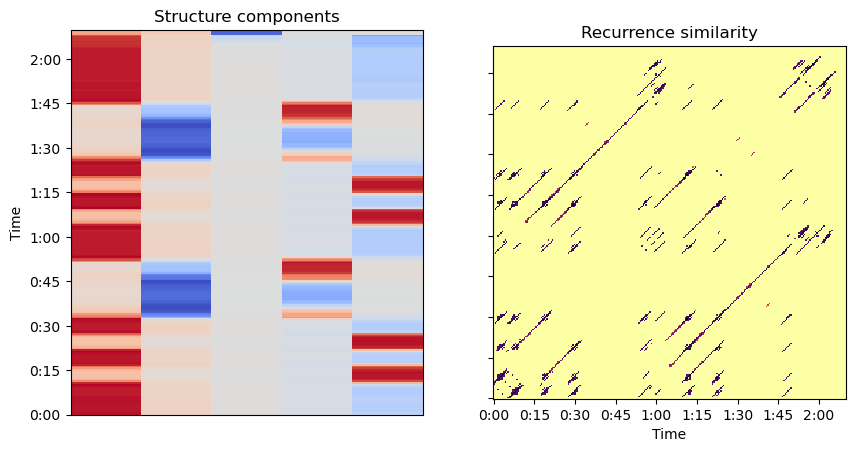

In [10]:
L = scipy.sparse.csgraph.laplacian(A, normed=True)


# and its spectral decomposition
evals, evecs = scipy.linalg.eigh(L)


# We can clean this up further with a median filter.
# This can help smooth over small discontinuities
evecs = scipy.ndimage.median_filter(evecs, size=(9, 1))


# cumulative normalization is needed for symmetric normalize laplacian eigenvectors
Cnorm = np.cumsum(evecs**2, axis=1)**0.5

# If we want k clusters, use the first k normalized eigenvectors.
# Fun exercise: see how the segmentation changes as you vary k

k = 5

X = evecs[:, :k] / Cnorm[:, k-1:k]


# Plot the resulting representation (Figure 1, center and right)

fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(10, 5))
librosa.display.specshow(Rf, cmap='inferno_r', y_axis='time', x_axis='time',
                         y_coords=beat_times, x_coords=beat_times, ax=ax[1])
ax[1].set(title='Recurrence similarity')
ax[1].label_outer()

librosa.display.specshow(X,
                         y_axis='time',
                         y_coords=beat_times, ax=ax[0])
ax[0].set(title='Structure components')

Let's use these k components to cluster beats into segments
(Algorithm 1)



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


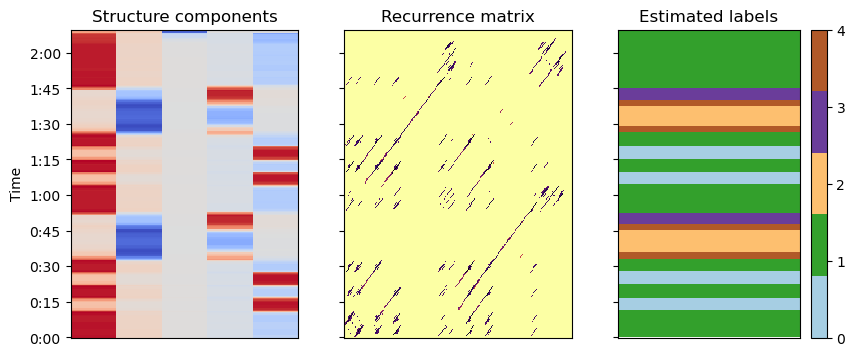

In [11]:
KM = sklearn.cluster.KMeans(n_clusters=k, n_init="auto")

seg_ids = KM.fit_predict(X)


# and plot the results
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(10, 4))
colors = plt.get_cmap('Paired', k)

librosa.display.specshow(Rf, cmap='inferno_r', y_axis='time',
                         y_coords=beat_times, ax=ax[1])
ax[1].set(title='Recurrence matrix')
ax[1].label_outer()

librosa.display.specshow(X,
                         y_axis='time',
                         y_coords=beat_times, ax=ax[0])
ax[0].set(title='Structure components')

img = librosa.display.specshow(np.atleast_2d(seg_ids).T, cmap=colors, 
                         y_axis='time',
                         x_coords=[0, 1], y_coords=list(beat_times) + [beat_times[-1]], 
                         ax=ax[2])
ax[2].set(title='Estimated labels')

ax[2].label_outer()
fig.colorbar(img, ax=[ax[2]], ticks=range(k))

Locate segment boundaries from the label sequence



In [12]:
bound_beats = 1 + np.flatnonzero(seg_ids[:-1] != seg_ids[1:])

# Count beat 0 as a boundary
bound_beats = librosa.util.fix_frames(bound_beats, x_min=0)

# Compute the segment label for each boundary
bound_segs = list(seg_ids[bound_beats])

# Convert beat indices to frames
bound_frames = beats[bound_beats]

# Make sure we cover to the end of the track
bound_frames = librosa.util.fix_frames(bound_frames,
                                       x_min=None,
                                       x_max=C.shape[1]-1)

And plot the final segmentation over original CQT



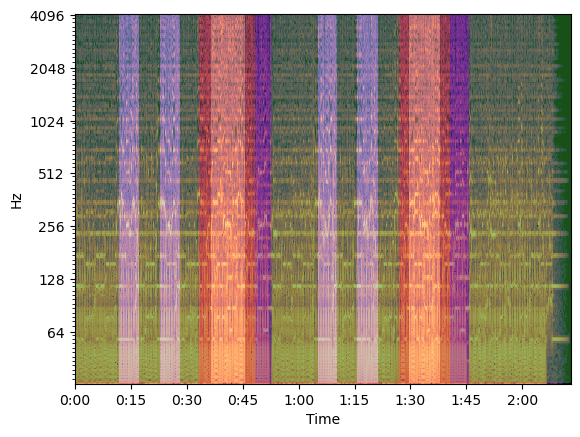

In [13]:
# sphinx_gallery_thumbnail_number = 5

import matplotlib.patches as patches
bound_times = librosa.frames_to_time(bound_frames)
freqs = librosa.cqt_frequencies(n_bins=C.shape[0],
                                fmin=librosa.note_to_hz('C1'),
                                bins_per_octave=BINS_PER_OCTAVE)

fig, ax = plt.subplots()
librosa.display.specshow(C, y_axis='cqt_hz', sr=sr,
                         bins_per_octave=BINS_PER_OCTAVE,
                         x_axis='time', ax=ax)

for interval, label in zip(zip(bound_times, bound_times[1:]), bound_segs):
    ax.add_patch(patches.Rectangle((interval[0], freqs[0]),
                                   interval[1] - interval[0],
                                   freqs[-1],
                                   facecolor=colors(label),
                                   alpha=0.50))